<a href="https://colab.research.google.com/github/AlejandraOcampo23/Ciencia-De-Datos/blob/main/206_Alejandra_Ocampo_Escobar_Taller2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Alejandra Ocampo Escobar**
Taller 2

Ciencia de Datos













SOKNYWQZJREL3HL2ONIT343PAQ (1).avif

---



En el mundo financiero, los bancos buscan constantemente formas de obtener recursos para financiar sus actividades y operaciones. Una de las formas más comunes es la emisión de Certificados de Depósito a Término (CDT), los cuales son adquiridos por los clientes. El reto para los bancos empieza cal momento de predecir si un cliente va a adquirir uno de estos productos. En este taller, se trabajará con una base de datos de campañas de mercadeo de un banco, con el objetivo de predecir si un cliente adquirira o no un CDT.

In [566]:
#Descargamos las librerias que vamos a usar
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/AlejandraOcampo23/Ciencia-De-Datos.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'Ciencia-De-Datos' already exists and is not an empty directory.


In [567]:
#Descargamos Base de datos Train
train=pd.read_csv("/content/drive/MyDrive/Ciencia de Datos/train.csv")
print(train.shape)
train.head(1)

(40179, 20)


,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,0


In [568]:
#Descargamos base de datos de prediccion
pred=pd.read_csv("/content/drive/MyDrive/Ciencia de Datos/pred.csv")
print(pred.shape)
pred.head(1)

(1009, 19)


,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed
0,12692,37,technician,single,university.degree,no,no,no,cellular,jul,mon,3,999,0,nonexistent,1.4,93.918,-42.7,5228.1


In [569]:
#Unimos datasets train y pred y dejamos una columna llamada dataset ya que mas adelante los vamos a separar para poder hacer nuestras predicciones
train['dataset'] = 'train'
pred['dataset'] = 'pred'

train.set_index('id', inplace=True)
pred.set_index('id', inplace=True)

train_pred = train.append(pred)

train_pred.tail(5)

<ipython-input-569-7ab9b0569e65>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_pred = train.append(pred)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,dataset
id,,,,,,,,,,,,,,,,,,,,
36468,40,blue-collar,divorced,professional.course,no,no,no,cellular,jun,wed,2,3,1,success,-2.9,92.963,-40.8,5076.2,NaN,pred
39654,45,blue-collar,married,professional.course,no,yes,no,telephone,may,thu,1,6,2,success,-1.8,93.876,-40.0,5008.7,NaN,pred
37695,34,admin.,single,university.degree,no,no,no,cellular,aug,wed,1,999,0,nonexistent,-2.9,92.201,-31.4,5076.2,NaN,pred
39315,29,technician,single,professional.course,no,yes,yes,cellular,mar,thu,2,13,1,success,-1.8,93.369,-34.8,5008.7,NaN,pred
39221,34,admin.,single,university.degree,no,no,no,cellular,mar,tue,1,6,1,success,-1.8,93.369,-34.8,5008.7,NaN,pred


In [570]:
#Renombramos las columnas, en esta caso lo haremos porque nos facilita mas recordarlas y entenderlas en español
nuevas_col = ['edad','trabajo','estado.civil','educacion','default',
              'housing','deuda','contacto','mes',"dia",
              'campana','pdays','previo', 'poutcome','emp_var',
              'cons_price','cons_conf','nr_employed','target','dataset']
train_pred.columns = nuevas_col
train_pred.tail(1)

,edad,trabajo,estado.civil,educacion,default,housing,deuda,contacto,mes,dia,campana,pdays,previo,poutcome,emp_var,cons_price,cons_conf,nr_employed,target,dataset
id,,,,,,,,,,,,,,,,,,,,
39221,34,admin.,single,university.degree,no,no,no,cellular,mar,tue,1,6,1,success,-1.8,93.369,-34.8,5008.7,NaN,pred


<Axes: >

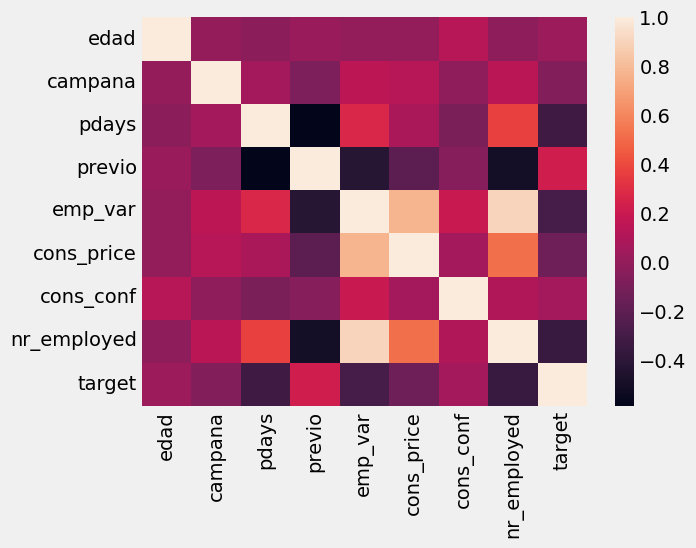

In [571]:
#Vemos la correlacion de las diferentes variables en esta caso las numericas, con el fin de crear nuevas variables o saber cuales borrar
corr = train_pred.corr()
sns.heatmap(corr)

In [572]:
# observamos la correlacion que existe entre las variable nr employed y emp.var rate por lo que crearemos una variable de estas dos
# en primer lugar siendo una el numero de empleos y la otra la variacion que ha tenido de empleos en esta caso trimestrestral, los mismo pasa
#con las variables de consumidor por lo que crearemos dos variables una de total de empleo y otra con el total de precio del consumidor que son mensuales
#esto con el fin de recoger la informacion en una sola variable y poder eliminar columnas

In [573]:
#Creamos una variables para el total de empleos y otra para el total de prices
train_pred["total.emp"]= (train_pred.nr_employed + train_pred.emp_var/-4) #lo dividimos en 4 porque son la cantidad de trimestres que hay en 1 año
train_pred["total.price"]= (train_pred.cons_conf + train_pred.cons_price/-12) #lo dividimos en 12 porque son la cantidad de meses que hay en 1 año

In [574]:
#Creamos un dataset con nuestras nuevas variables
train_pred_dummy= train_pred.groupby("id").agg(empleos=("total.emp","mean"),precios=("total.price","mean")).reset_index()
train_pred_dummy.head(1)

,id,empleos,precios
0,0,5190.725,-44.232833


In [575]:
#Unimos los dos datasets,con el que estamos trabajando y el de nuestras nuevas variables
merge_train_pred = pd.merge(train_pred.loc[:,nuevas_col],train_pred_dummy,on="id",how="left")
merge_train_pred.head(1)

,id,edad,trabajo,estado.civil,educacion,default,housing,deuda,contacto,mes,dia,campana,pdays,previo,poutcome,emp_var,cons_price,cons_conf,nr_employed,target,dataset,empleos,precios
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,0.0,train,5190.725,-44.232833


In [576]:
#Ahora vamos a eliminar las columnas que ya no vamos a necesitar puesto que nuestras variables ya reunen esta informacion y seria repetirla
col_eliminar = ['emp_var',"cons_price","cons_conf","nr_employed"]
merge_train_pred= train_pred.loc[:,~train_pred.columns.isin(col_eliminar)]
merge_train_pred.head(1)

,edad,trabajo,estado.civil,educacion,default,housing,deuda,contacto,mes,dia,campana,pdays,previo,poutcome,target,dataset,total.emp,total.price
id,,,,,,,,,,,,,,,,,,
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0.0,train,5190.725,-44.232833


In [577]:
#Ahora vamos a traer la informacion de nuestro dataset con el fin de identificar si hay valores nulos
merge_train_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 39221
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   edad          41188 non-null  int64  
 1   trabajo       41188 non-null  object 
 2   estado.civil  41188 non-null  object 
 3   educacion     41188 non-null  object 
 4   default       41188 non-null  object 
 5   housing       41188 non-null  object 
 6   deuda         41188 non-null  object 
 7   contacto      41188 non-null  object 
 8   mes           41188 non-null  object 
 9   dia           41188 non-null  object 
 10  campana       41188 non-null  int64  
 11  pdays         41188 non-null  int64  
 12  previo        41188 non-null  int64  
 13  poutcome      41188 non-null  object 
 14  target        40179 non-null  float64
 15  dataset       41188 non-null  object 
 16  total.emp     41188 non-null  float64
 17  total.price   41188 non-null  float64
dtypes: float64(3), int64(4), o

In [578]:
#Nos damos cuenta que solo la columna target tiene valores nulos, por lo que vamos a imputarlos
target1 =merge_train_pred.target.mode()[0]
merge_train_pred.loc[merge_train_pred.target.isna(),'target'] = target1

In [579]:
#Revisamos otra vez la info para saber que no hayan mas valores nulos
merge_train_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 39221
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   edad          41188 non-null  int64  
 1   trabajo       41188 non-null  object 
 2   estado.civil  41188 non-null  object 
 3   educacion     41188 non-null  object 
 4   default       41188 non-null  object 
 5   housing       41188 non-null  object 
 6   deuda         41188 non-null  object 
 7   contacto      41188 non-null  object 
 8   mes           41188 non-null  object 
 9   dia           41188 non-null  object 
 10  campana       41188 non-null  int64  
 11  pdays         41188 non-null  int64  
 12  previo        41188 non-null  int64  
 13  poutcome      41188 non-null  object 
 14  target        41188 non-null  float64
 15  dataset       41188 non-null  object 
 16  total.emp     41188 non-null  float64
 17  total.price   41188 non-null  float64
dtypes: float64(3), int64(4), o

**Outliers**

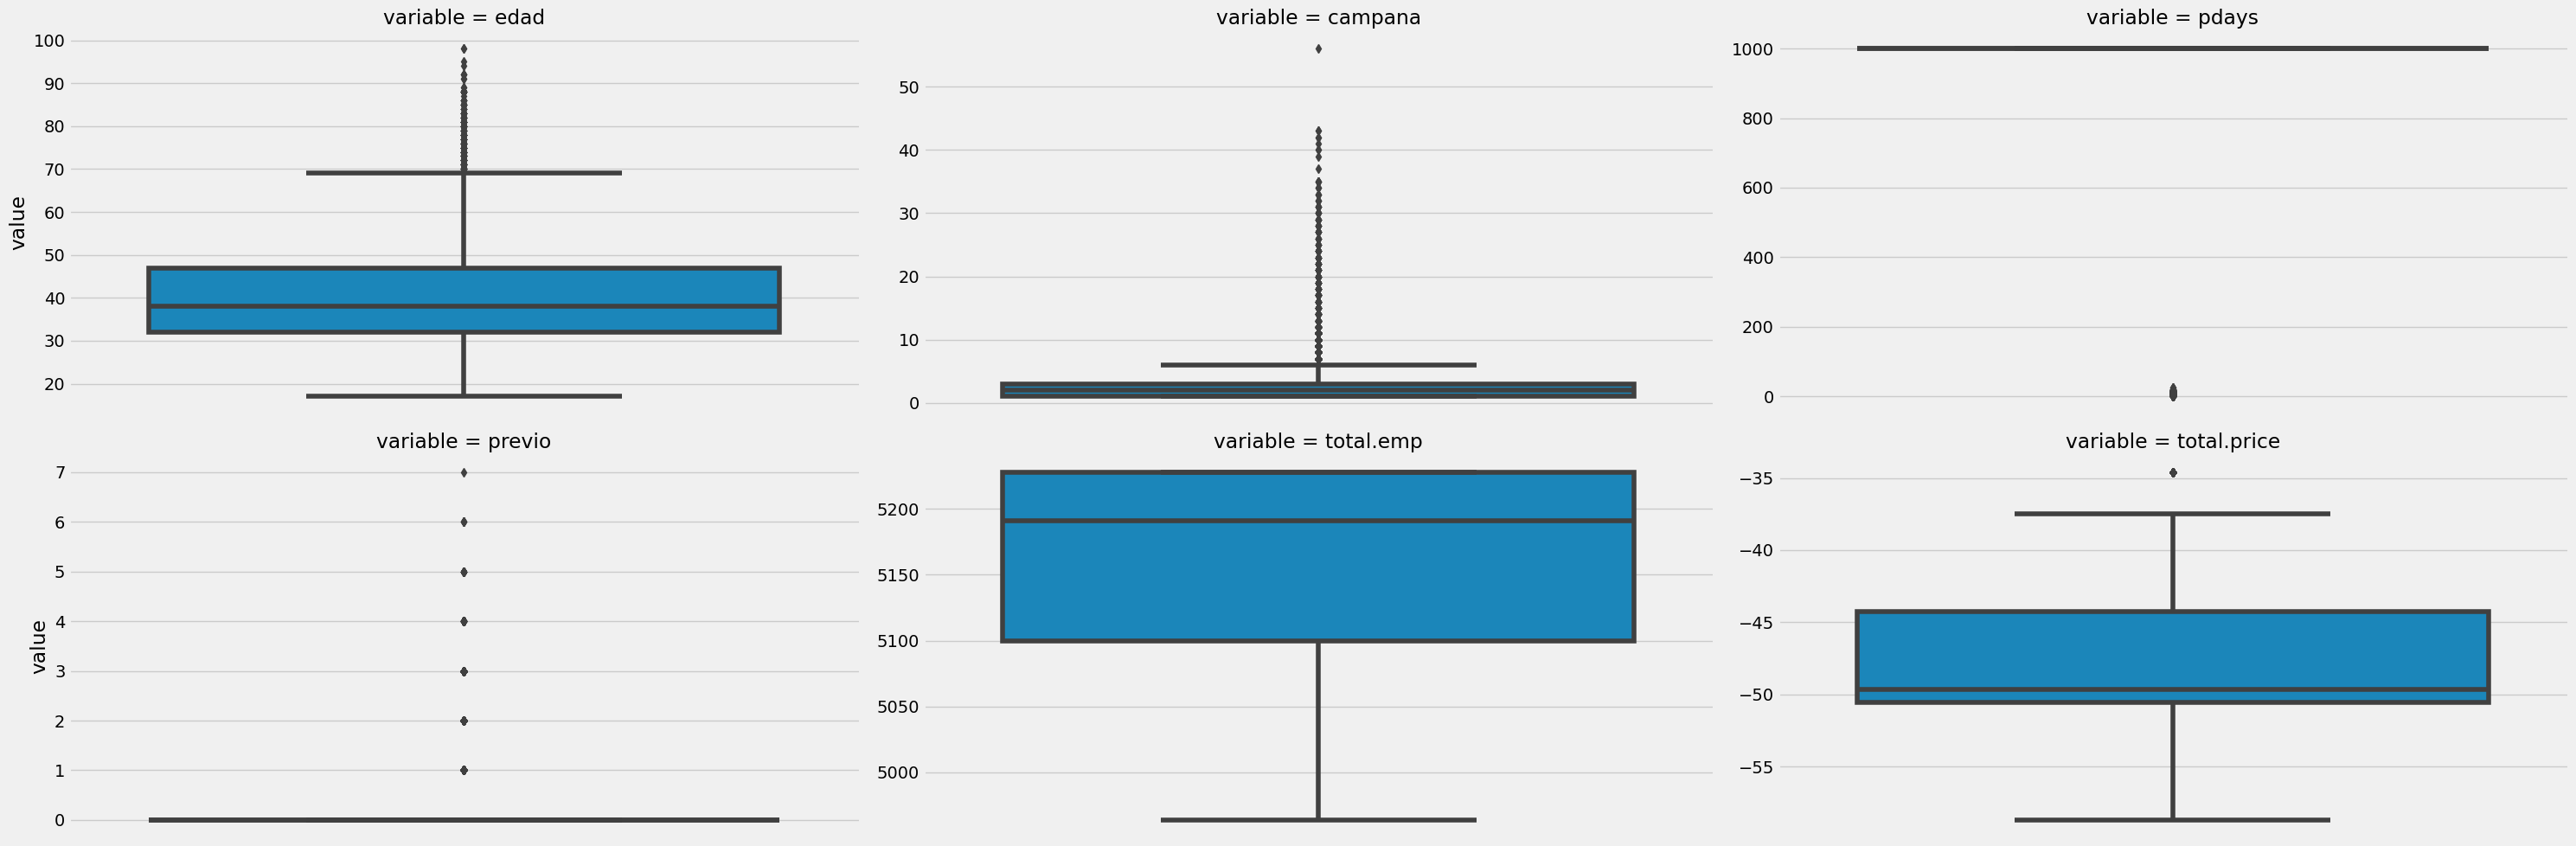

In [580]:
#Se va realizar un tratamiento de outliers, es decir de los valores atipicos que se puedan encontrar en nuestro dataset
#para esto comenzaremos realizando unos boxplot para poder identificar estos valores
columnas_num = ["edad",'campana', 'pdays', 'previo', "total.emp", "total.price"]
melt_num = pd.melt(merge_train_pred.loc[:,merge_train_pred.columns.isin(columnas_num)],value_vars=columnas_num)
sns.catplot(data=melt_num,y='value',col='variable',col_wrap=3,kind='box',sharey=False,aspect=2)

In [581]:
#Realizamos la correcion de los valores atipicos
for columna in columnas_num:
    q1 = train_pred[columna].quantile(0.25)
    q3 = train_pred[columna].quantile(0.75)
    iqr = q3-q1 
    limite_arriba = q3 + 1.5*iqr
    limite_abajo = q1 - 1.5*iqr
    mediana = merge_train_pred.loc[merge_train_pred[columna]<q3 + 1.5*iqr, columna].median()
    media = train_pred[columna].mean()
    merge_train_pred.loc[merge_train_pred[columna].abs() > limite_arriba,columna] = np.nan
    merge_train_pred[columna].fillna(limite_arriba, inplace=True)
    merge_train_pred.loc[merge_train_pred[columna].abs() < limite_abajo,columna] = np.nan
    merge_train_pred[columna].fillna(limite_abajo, inplace=True) 

<ipython-input-581-6fb100fd777e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_train_pred.loc[merge_train_pred[columna].abs() > limite_arriba,columna] = np.nan
<ipython-input-581-6fb100fd777e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_train_pred[columna].fillna(limite_arriba, inplace=True)
<ipython-input-581-6fb100fd777e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

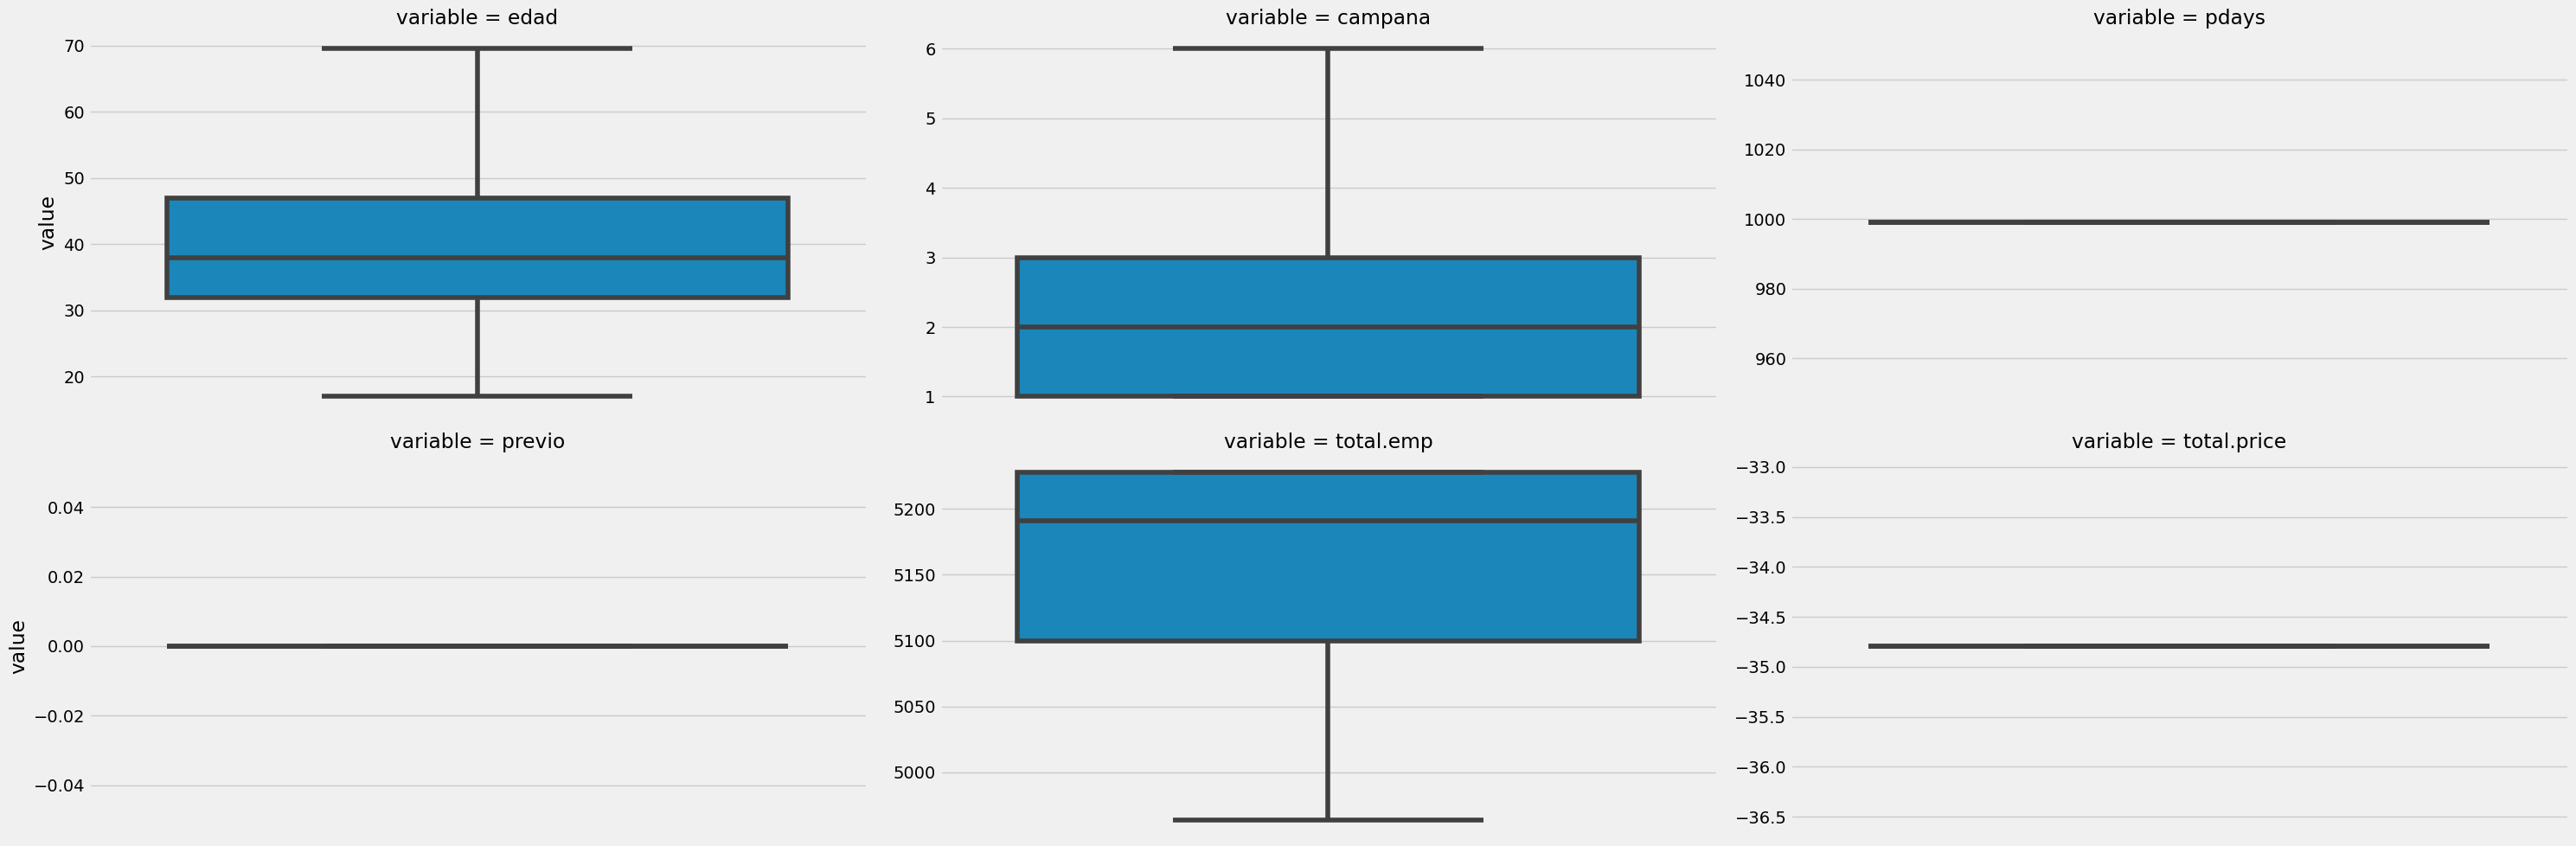

In [582]:
#Y volvemos a revisar el boxplot
melt_num = pd.melt(merge_train_pred.loc[:,merge_train_pred.columns.isin(columnas_num)],value_vars=columnas_num)
sns.catplot(data=melt_num,y='value',col='variable',col_wrap=3,kind='box',sharey=False,aspect=2)

In [583]:
#Apartir de la correcion de outliers y las graficas de boxplot nos damos cuenta que las variables
#pdays, previo y total.price son insignificantes o no son relevantes para nuestro modelo por lo que
#procederemos a eliminarlas de nuestro dataset
col_eliminar = ['pdays',"previo","total.price"]
train_pred1= merge_train_pred.loc[:,~merge_train_pred.columns.isin(col_eliminar)]
train_pred1.head(3)

,edad,trabajo,estado.civil,educacion,default,housing,deuda,contacto,mes,dia,campana,poutcome,target,dataset,total.emp
id,,,,,,,,,,,,,,,
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1.0,nonexistent,0.0,train,5190.725
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,1.0,nonexistent,0.0,train,5190.725
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,1.0,nonexistent,0.0,train,5190.725


**Variables categoricas**

In [584]:
#Ahora vamos a revisar la correlacion entre las variables categoricas
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def cramersv_dataframe_target(dataframe,nameTarget):
    df = pd.DataFrame(columns=['v_cramer'],index=dataframe.columns.tolist())
    for col in dataframe.columns.tolist():
        print('V de Cramer para {}: '.format(col) + format(round(cramers_v(dataframe[col],dataframe[nameTarget]),3)))
        df.loc[col,'v_cramer'] = round(cramers_v(dataframe[col],dataframe[nameTarget]),3)
    return df

In [585]:
def cramersv_dataframe(dataframe):
    df = pd.DataFrame(columns=dataframe.columns.tolist(),index=dataframe.columns.tolist())
    for index in dataframe.columns.tolist():
        for columna in dataframe.columns.tolist():
            df.loc[index,columna] = round(cramers_v(dataframe[index],dataframe[columna]),3)
    return df
        
lista_var_cat = []
for columna in train_pred1.columns:
    if train_pred1[columna].dtypes=='O':
        lista_var_cat.append(columna)

In [586]:
cramer_df = cramersv_dataframe(train_pred1.loc[:,lista_var_cat] )

In [587]:
#Correlacion entre las variables categoricas
cramer_df

,trabajo,estado.civil,educacion,default,housing,deuda,contacto,mes,dia,poutcome,dataset
trabajo,1.0,0.184,0.36,0.152,0.011,0.01,0.128,0.11,0.016,0.1,0.0
estado.civil,0.184,1.0,0.116,0.095,0.009,0.0,0.072,0.05,0.011,0.037,0.003
educacion,0.36,0.116,1.0,0.17,0.013,0.0,0.123,0.095,0.02,0.042,0.013
default,0.152,0.095,0.17,1.0,0.011,0.002,0.136,0.112,0.011,0.077,0.008
housing,0.011,0.009,0.013,0.011,1.0,0.708,0.085,0.054,0.015,0.017,0.002
deuda,0.01,0.0,0.0,0.002,0.708,1.0,0.024,0.02,0.006,0.0,0.0
contacto,0.128,0.072,0.123,0.136,0.085,0.024,1.0,0.609,0.055,0.242,0.007
mes,0.11,0.05,0.095,0.112,0.054,0.02,0.609,1.0,0.067,0.242,0.02
dia,0.016,0.011,0.02,0.011,0.015,0.006,0.055,0.067,1.0,0.015,0.01
poutcome,0.1,0.037,0.042,0.077,0.017,0.0,0.242,0.242,0.015,1.0,0.028


In [588]:
#Eliminamos la columna de dia ya que es irrelevantes para nuestro modelo
col_eliminar = ["dia"]
train_pred1= train_pred1.loc[:,~train_pred1.columns.isin(col_eliminar)]
train_pred1.head(3)

,edad,trabajo,estado.civil,educacion,default,housing,deuda,contacto,mes,campana,poutcome,target,dataset,total.emp
id,,,,,,,,,,,,,,
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,1.0,nonexistent,0.0,train,5190.725
1,57.0,services,married,high.school,unknown,no,no,telephone,may,1.0,nonexistent,0.0,train,5190.725
2,37.0,services,married,high.school,no,yes,no,telephone,may,1.0,nonexistent,0.0,train,5190.725


In [589]:
#Ahora bien,en primer lugar vamos a tomar la variable mes, la cual vamos a encodear y de seguido la vamos a separar en los dos semestres del año
#esto debido a que es mas probable que se tome un cdt en el primer semestre del año que en el segundo
#todo a razon de los cierres fiscales que hay a fin de año

In [590]:
#Encodear columna mes, es decir volverla numerica en esta caso cada mes del año tomara un valor
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_pred1['mes'] = le.fit_transform(train_pred1['mes'])
train_pred1.head()

<ipython-input-590-77c5e8a1cd7f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_pred1['mes'] = le.fit_transform(train_pred1['mes'])


,edad,trabajo,estado.civil,educacion,default,housing,deuda,contacto,mes,campana,poutcome,target,dataset,total.emp
id,,,,,,,,,,,,,,
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,6,1.0,nonexistent,0.0,train,5190.725
1,57.0,services,married,high.school,unknown,no,no,telephone,6,1.0,nonexistent,0.0,train,5190.725
2,37.0,services,married,high.school,no,yes,no,telephone,6,1.0,nonexistent,0.0,train,5190.725
3,40.0,admin.,married,basic.6y,no,no,no,telephone,6,1.0,nonexistent,0.0,train,5190.725
4,56.0,services,married,high.school,no,no,yes,telephone,6,1.0,nonexistent,0.0,train,5190.725


In [591]:
#Teniendo ya la variable como una variable numerica pasamos a dividirla en los dos semestres del año, es decir
#los que tengan un numero menor a 6 pertenecen al primer semestre del año y al contrario serian del segundo semestre del año
train_pred1['semestre'] = train_pred1['mes'].apply(lambda x: 'primer semestre' if x <= 6 else 'segundo semestre')
train_pred1 = train_pred1.drop('mes', axis=1)

In [592]:
#Ahora la volveremos una variable binaria donde el primer semestre sera 0 y el segundo 1 
train_pred1['semestre'] = le.fit_transform(train_pred1['semestre'])

In [593]:
#Observamos como queda nuestra variable semestre
train_pred1.head(3)

,edad,trabajo,estado.civil,educacion,default,housing,deuda,contacto,campana,poutcome,target,dataset,total.emp,semestre
id,,,,,,,,,,,,,,
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,1.0,nonexistent,0.0,train,5190.725,0
1,57.0,services,married,high.school,unknown,no,no,telephone,1.0,nonexistent,0.0,train,5190.725,0
2,37.0,services,married,high.school,no,yes,no,telephone,1.0,nonexistent,0.0,train,5190.725,0


In [594]:
#Asi como lo hicimos anterior, podemos unir las variables que nos representan la deuda del cliente, en este caso
#el default que es sobre si tiene creditos en mora, la deuda y housing que representa la deuda de housing, esto nos puede
#indicar mejor la situacion financiera del cliente y si tiene capital o no para adquirir el cdt

#Para esto las unimos y al ser categorica indicamos que el no sera un 0 y el si un 1
train_pred1["deuda_total"] = train_pred1[["default", "housing", "deuda"]].replace({"no": 0, "yes": 1}).sum(axis=1)


<ipython-input-594-eba444f6aae9>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_pred1["deuda_total"] = train_pred1[["default", "housing", "deuda"]].replace({"no": 0, "yes": 1}).sum(axis=1)


In [595]:
#Eliminamos las variables que ya no vamos a necesitar pq ya estan unidas en nuestra variable deuda total
col_eliminar = ["default","housing","deuda"]
train_pred1= train_pred1.loc[:,~train_pred1.columns.isin(col_eliminar)]
train_pred1.head(3)

,edad,trabajo,estado.civil,educacion,contacto,campana,poutcome,target,dataset,total.emp,semestre,deuda_total
id,,,,,,,,,,,,
0,56.0,housemaid,married,basic.4y,telephone,1.0,nonexistent,0.0,train,5190.725,0,0.0
1,57.0,services,married,high.school,telephone,1.0,nonexistent,0.0,train,5190.725,0,0.0
2,37.0,services,married,high.school,telephone,1.0,nonexistent,0.0,train,5190.725,0,0.0


In [596]:
#Ahora vmos a transformar la variable trabajo y la poutcome en variables numericas
train_pred1['poutcome'] = le.fit_transform(train_pred1['poutcome'])
train_pred1['trabajo'] = le.fit_transform(train_pred1['trabajo'])

In [597]:
#Para la variable educacion pasa algo similar a los meses, esta esa dividad en educacion basica y superio
#por lo que primero la vamos a volver numerica y las menores a 4 las nombrares como educacion basica y las
#superiores a 4 seran de educacion superior
train_pred1['educacion'] = le.fit_transform(train_pred1['educacion'])
train_pred1['nivel_educacion'] = train_pred1['educacion'].apply(lambda x: 'basica' if x <= 4 else 'superior')
train_pred1 = train_pred1.drop('educacion', axis=1)
train_pred1['nivel_educacion'] = le.fit_transform(train_pred1['nivel_educacion'])
train_pred1.head(4)

,edad,trabajo,estado.civil,contacto,campana,poutcome,target,dataset,total.emp,semestre,deuda_total,nivel_educacion
id,,,,,,,,,,,,
0,56.0,3,married,telephone,1.0,1,0.0,train,5190.725,0,0.0,0
1,57.0,7,married,telephone,1.0,1,0.0,train,5190.725,0,0.0,0
2,37.0,7,married,telephone,1.0,1,0.0,train,5190.725,0,0.0,0
3,40.0,0,married,telephone,1.0,1,0.0,train,5190.725,0,0.0,0


In [598]:
#Ahora bien usaremos el metodo de One Hot para encodear la variable estado civil y contacto
#para pasarlas de categoricas a numerica, este metodo lo usamos ya que son variables nominales por lo que 
#sus categorias no tienen un orden especifico
columnas_encodear = ["estado.civil","contacto"]
train_pred_ohe = pd.get_dummies(train_pred1, columns=columnas_encodear, prefix='OHE')
train_pred_ohe.head(2)

,edad,trabajo,campana,poutcome,target,dataset,total.emp,semestre,deuda_total,nivel_educacion,OHE_divorced,OHE_married,OHE_single,OHE_unknown,OHE_cellular,OHE_telephone
id,,,,,,,,,,,,,,,,
0,56.0,3,1.0,1,0.0,train,5190.725,0,0.0,0,0,1,0,0,0,1
1,57.0,7,1.0,1,0.0,train,5190.725,0,0.0,0,0,1,0,0,0,1


In [599]:
#Creamos nuestro nuevo dataset con las nuevas columnas que creamos en el metodo One-Hot
train_df = train_pred_ohe.loc[train_pred_ohe.dataset=='train',train_pred_ohe.columns!='dataset']
test_df = train_pred_ohe.loc[train_pred_ohe.dataset=='pred',train_pred_ohe.columns!='dataset']
train_df.head(1)

,edad,trabajo,campana,poutcome,target,total.emp,semestre,deuda_total,nivel_educacion,OHE_divorced,OHE_married,OHE_single,OHE_unknown,OHE_cellular,OHE_telephone
id,,,,,,,,,,,,,,,
0,56.0,3,1.0,1,0.0,5190.725,0,0.0,0,0,1,0,0,0,1


# **Train-Test Split**

In [600]:
#Como se habia mencionado al principio, volveremos a separa nuestros dataset en los originales
#en este caso el de train y el de pred que lo llamares test
x_train = pd.DataFrame(train_df.loc[:,train_df.columns!='target'])
y_train = pd.DataFrame(train_df.loc[:,"target"])

x_test = pd.DataFrame(test_df.loc[:,test_df.columns!='target'])
y_test = pd.DataFrame(test_df.loc[:,"target"])

In [601]:
print("Tamaño x train"+format(x_train.shape))
print("Tamaño y train"+format(y_train.shape))
print("Tamaño x test"+format(x_test.shape))
print("Tamaño y test"+format(y_test.shape))

Tamaño x train(40179, 14)
Tamaño y train(40179, 1)
Tamaño x test(1009, 14)
Tamaño y test(1009, 1)


# **Arbol de decision**

In [602]:
#En esta ejemplo vamos usar el arbol de decision el cual es un modelo de
#aprendizaje automatico, en este caso lo usaremos para
#predecir si un cliente va adquirir un CDT o no
modelo_arbol = DecisionTreeClassifier(max_depth = 10)
modelo_arbol.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=10)

In [603]:
#Nos indica que nuestro arbol de decision tiene un rendimiento de
# el 0.7359
scores = cross_val_score(modelo_arbol, x_train, y_train, cv = 5, scoring='accuracy')
scores.mean()

0.736252030765104

In [604]:
#En este codigo estamos realizando una prediccion de nuestro arbol de decision
#tomando la columna id y target
pred_arbol=pd.DataFrame(modelo_arbol.predict(x_test),columns=["target"],index=x_test.index).reset_index()
pred_arbol.target=pred_arbol.target.astype(int)

In [605]:
#Con este codigo descargamos el csv para subirlo a Kaggle
from google.colab import files
pred_arbol.to_csv("pred1.csv",index=False)
files.download("pred1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [606]:
#Aqui vamos usar la medida de precision del modelo F1
#en este caso para nuestro arbol de decision
# el cual nos indica un 0.4257 de precision
from sklearn.metrics import f1_score
y_pred = modelo_arbol.predict(x_train)
f1 = f1_score(y_train, y_pred)

print("F1-Score:", f1)

F1-Score: 0.4250245017967984


# **Random Forest**

In [607]:
#Ahora bien utilizaremos el modelo de aprendizaje Random forest
#que a diferencia del arbol de decision este usa varios arboles
modelo_rf=RandomForestClassifier(n_estimators=200,random_state=44)
modelo_rf.fit(x_train,y_train)

<ipython-input-607-435f923b40dd>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(x_train,y_train)


RandomForestClassifier(n_estimators=200, random_state=44)

In [608]:
##Nos indica que nuestro random forest tiene un rendimiento de
# el 0.688341
scores = cross_val_score(modelo_rf, x_train, y_train, cv = 5, scoring='accuracy')
print(scores.mean());

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 

0.6883415451872918


In [609]:
#En este codigo estamos realizando una prediccion de nuestro random forest
#tomando la columna id y target
pred_arbol_pod = pd.DataFrame(modelo_rf.predict(x_test),columns=['target'],index=test_df.index).reset_index()
pred_arbol_pod.target = pred_arbol_pod.target.astype(int)

In [610]:
#Con este codigo descargamos el csv para subirlo a Kaggle
pred_arbol_pod.to_csv("pred2.csv",index=False)
files.download("pred2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [611]:
#Aqui vamos usar la medida de precision del modelo F1
#en este caso para nuestro random forest
# el cual nos indica un 0.751569 de precision
from sklearn.metrics import f1_score

y_pred = modelo_rf.predict(x_train)
f1 = f1_score(y_train, y_pred)

print("F1-Score:", f1)

F1-Score: 0.7513661202185792


# **Regresion Logistica**

In [612]:
#Se van a crear las variables para realizar nuestra regresion logistica
scaler = MinMaxScaler()
train_norm = train_pred_ohe.loc[train_pred_ohe.dataset=='train',~train_pred_ohe.columns.isin(['dataset','target'])]
train_norm = pd.DataFrame(scaler.fit_transform(train_norm),index=train_norm.index,
                      columns=train_norm.columns)

test_norm = train_pred_ohe.loc[train_pred_ohe.dataset=='pred',~train_pred_ohe.columns.isin(['dataset','target'])]
test_norm = pd.DataFrame(scaler.fit_transform(test_norm),index=test_norm.index,
                      columns=test_norm.columns)

In [613]:
X = train_norm.loc[:,train_norm.columns!='target']
y = train_df["target"]

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X, y, test_size= 0.3, random_state=42)

In [614]:
#Entrenamos nuestro modelo de regresion logistica
reg_log = linear_model.LogisticRegression(max_iter=1000)
reg_log.fit(train_norm, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [615]:
#Generamos las predicciones
pred_rl = pd.DataFrame(reg_log.predict(test_norm),columns=["target"],index=test_norm.index).reset_index()
pred_rl.target = pred_rl.target.astype(int)

In [616]:
#Veremos cuales son las variables imporantes
acc_train_imp=accuracy_score(y_train_norm,reg_log.predict(X_train_norm))

acc_test_imp=accuracy_score(y_test_norm,reg_log.predict(X_test_norm))

In [617]:
#Nuestro Accuracy nos indica que la precision para train es de 0.9015
#Y para Test es de 0.9030
print("Train:"+format(acc_train_imp))
print("Test:"+format(acc_test_imp))

Train:0.9015111111111112
Test:0.9030197444831591


In [618]:
#Con este codigo descargamos el csv para subirlo a Kaggle
pred_rl.to_csv("pred3.csv",index=False)
files.download("pred3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [619]:
#Calculamos la importancia de cada variable en el modelo
def get_feature_importance(clf):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(14,25))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(x_train.columns)[sorted_idx], fontsize=12)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)

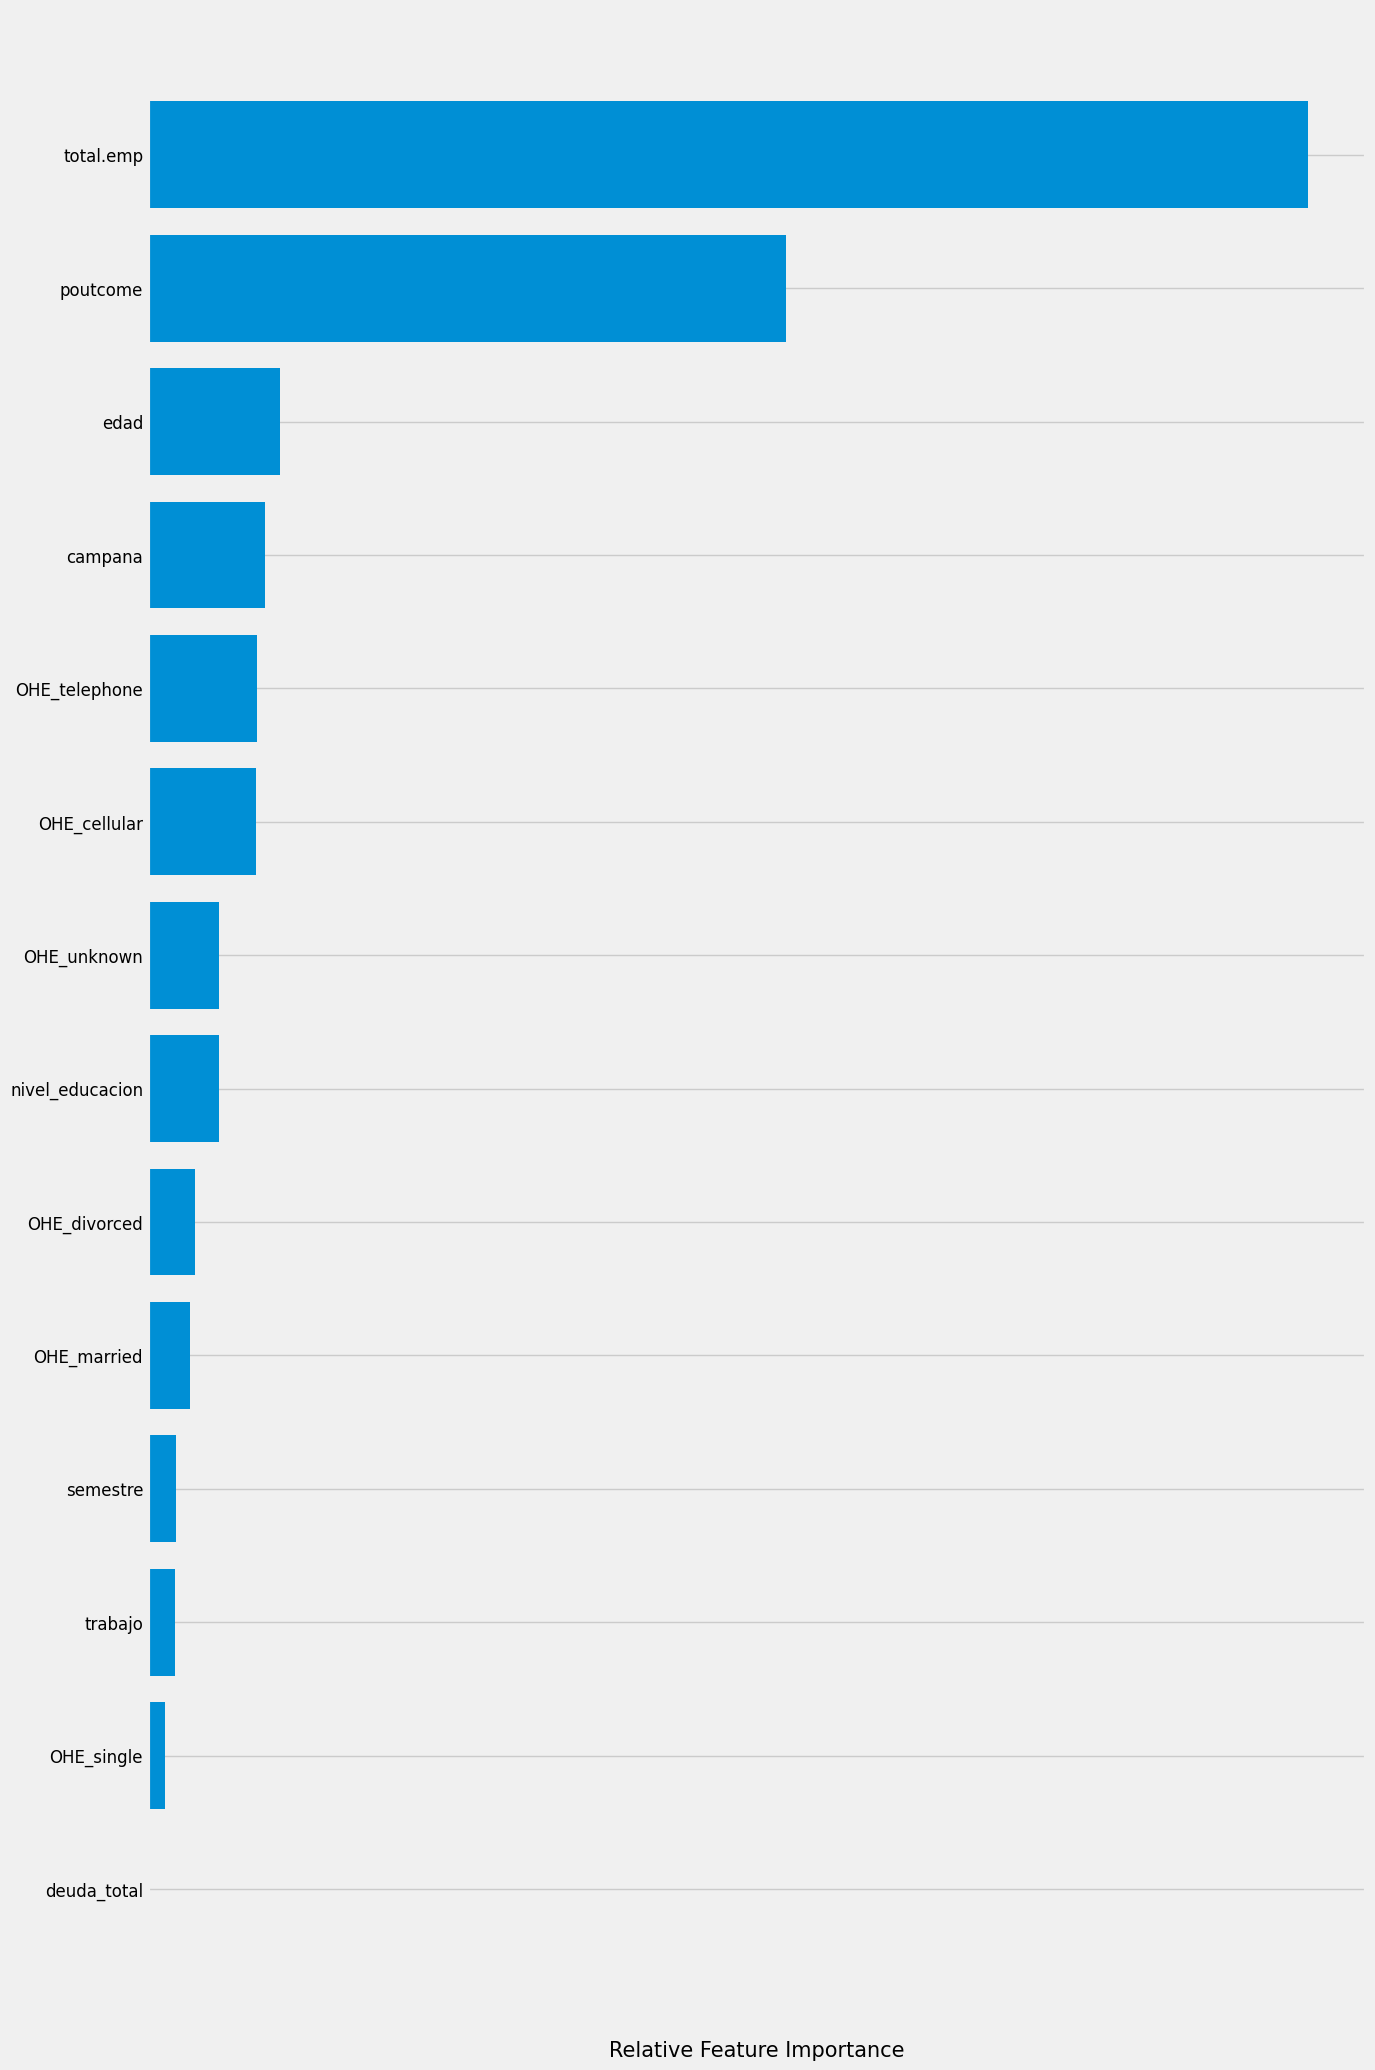

In [620]:
#Obtenemos la importancia de cada variable 
get_feature_importance(reg_log)

In [621]:
# Generamos predicciones
pred_train = pd.DataFrame(reg_log.predict(X_train_norm), columns=['prediccion'])

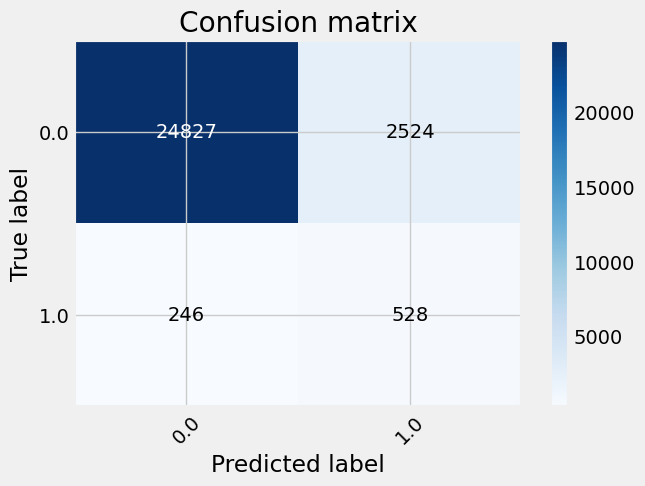

In [622]:
# Generamos la matriz de confusión
matriz_confusion = confusion_matrix(pred_train, y_train_norm)
plot_confusion_matrix_model(matriz_confusion, pred_train.prediccion.sort_values().unique(),
                           cmap=plt.cm.Blues)

In [623]:
#Obtenemos nombres de las variables más importantes
coeficientes = reg_log.coef_
abs_coeficientes = abs(coeficientes)
nombres_features = X_train_norm.columns
importancia_features = [(nombres_features[i], coeficientes[0][i]) for i in range(len(nombres_features))]
importancia_features_ordenada = sorted(importancia_features, key=lambda x: abs(x[1]), reverse=True)

In [624]:
len(importancia_features_ordenada)

14

In [625]:
# seleccionar las 14 variables más importantes

N = 14 
lista_columnas=[]
for i in range(N):
    print(importancia_features_ordenada[i])
    lista_columnas.append(importancia_features_ordenada[i][0])

('total.emp', -3.1910584796752355)
('poutcome', 1.7555164669899688)
('edad', 0.3626384207849902)
('campana', -0.321479049408951)
('OHE_telephone', -0.29981065887826847)
('OHE_cellular', 0.2961815693563711)
('OHE_unknown', 0.19465774474815)
('nivel_educacion', 0.1942563382907319)
('OHE_divorced', -0.12996056944583945)
('OHE_married', -0.11584210795055094)
('semestre', -0.07683878969345195)
('trabajo', 0.07295969000058569)
('OHE_single', 0.04751584312945337)
('deuda_total', 0.0)


In [626]:
# Volvemos a entrenar un modelo pero ahora solamente con las variables más importantes

X_train_importantes = X_train_norm.loc[:,lista_columnas]
X_test_importantes = X_test_norm.loc[:,lista_columnas]

reg_log_importantes = linear_model.LogisticRegression(multi_class='multinomial',
                                                     solver='lbfgs',max_iter=1000)

reg_log_importantes.fit(X_train_importantes, y_train_norm)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [627]:
#Obtenemos accuracy para el modelo con las variables más importantes
acc_train_imp = accuracy_score(y_train_norm,
            reg_log_importantes.predict(X_train_importantes))

acc_test_imp = accuracy_score(y_test_norm,
            reg_log_importantes.predict(X_test_importantes))


In [628]:
#El acurracy nos indica un 0.9014 para train y un 0.9031 para test
print('Train: '+format(acc_train_imp))
print('Test: '+format(acc_test_imp))

Train: 0.9014044444444445
Test: 0.9031027044964327


In [629]:
## cross validation
puntajes = cross_val_score(reg_log_importantes,X_train_importantes,
                          y_train_norm, scoring='accuracy', cv=5)
puntajes

array([0.90133333, 0.90204444, 0.90311111, 0.89902222, 0.90133333])

In [630]:
#Nuestro modelo con las variables importantes de regresion logistica
#nos predice el 0.9013
puntajes.mean()

0.901368888888889